<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Задание #2
## Анализ данных о сердечно-сосудистых заболеваниях

В этом задании вам предстоит ответить на вопросы по набору данных о сердечно-сосудистых заболеваниях. Загружать данные не нужно: они уже находятся в репозитории. В некоторых заданиях требуется написать код. Выполните их, а затем ответьте на вопросы в [форме](https://docs.google.com/forms/d/13cE_tSIb6hsScQvvWUJeu1MEHE5L6vnxQUbDYpXsf24).

#### Задача

Прогнозировать наличие или отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам обследования пациента.

#### Описание данных

Существует 3 типа входных признаков:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Признак                                                | Тип переменной      | Переменная  | Тип значения                                     |
|--------------------------------------------------------|---------------------|-------------|--------------------------------------------------|
| Возраст                                                | Objective Feature   | age         | int (days)                                       |
| Рост                                                   | Objective Feature   | height      | int (cm)                                         |
| Вес                                                    | Objective Feature   | weight      | float (kg)                                       |
| Пол                                                    | Objective Feature   | gender      | categorical code                                 |
| Систолическое артериальное давление                    | Examination Feature | ap_hi       | int                                              |
| Диастолическое артериальное давление                   | Examination Feature | ap_lo       | int                                              |
| Холестерин                                             | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Глюкоза                                                | Examination Feature | gluc        | 1: normal, 2: above normal, 3: well above normal |
| Курит                                                  | Subjective Feature  | smoke       | binary                                           |
| Употребляет алкоголь                                   | Subjective Feature  | alco        | binary                                           |
| Физическая активность                                  | Subjective Feature  | active      | binary                                           |
| Наличие или отсутствие сердечно-сосудистых заболеваний | Target Variable     | cardio      | binary                                           |

Все значения набора данных были собраны в момент медицинского осмотра.

Давайте познакомимся с нашими данными, проведя их предварительный анализ.

#  Часть 1. Предварительный анализ данных

Сначала мы инициализируем среду:

In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Для визуального анализа вы будете использовать библиотеку `seaborn`, поэтому давайте настроим и ее:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

Для простоты изложения мы будем работать только с обучающей частью набора данных:

In [3]:
df = pd.read_csv("../data/mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Было бы познавательно заглянуть в значения наших переменных.
 
Преобразуем данные в *long* формат и изобразим подсчеты значений категориальных признаков с помощью [`catplot()`](https://seaborn.pydata.org/generated/seaborn.catplot.html).

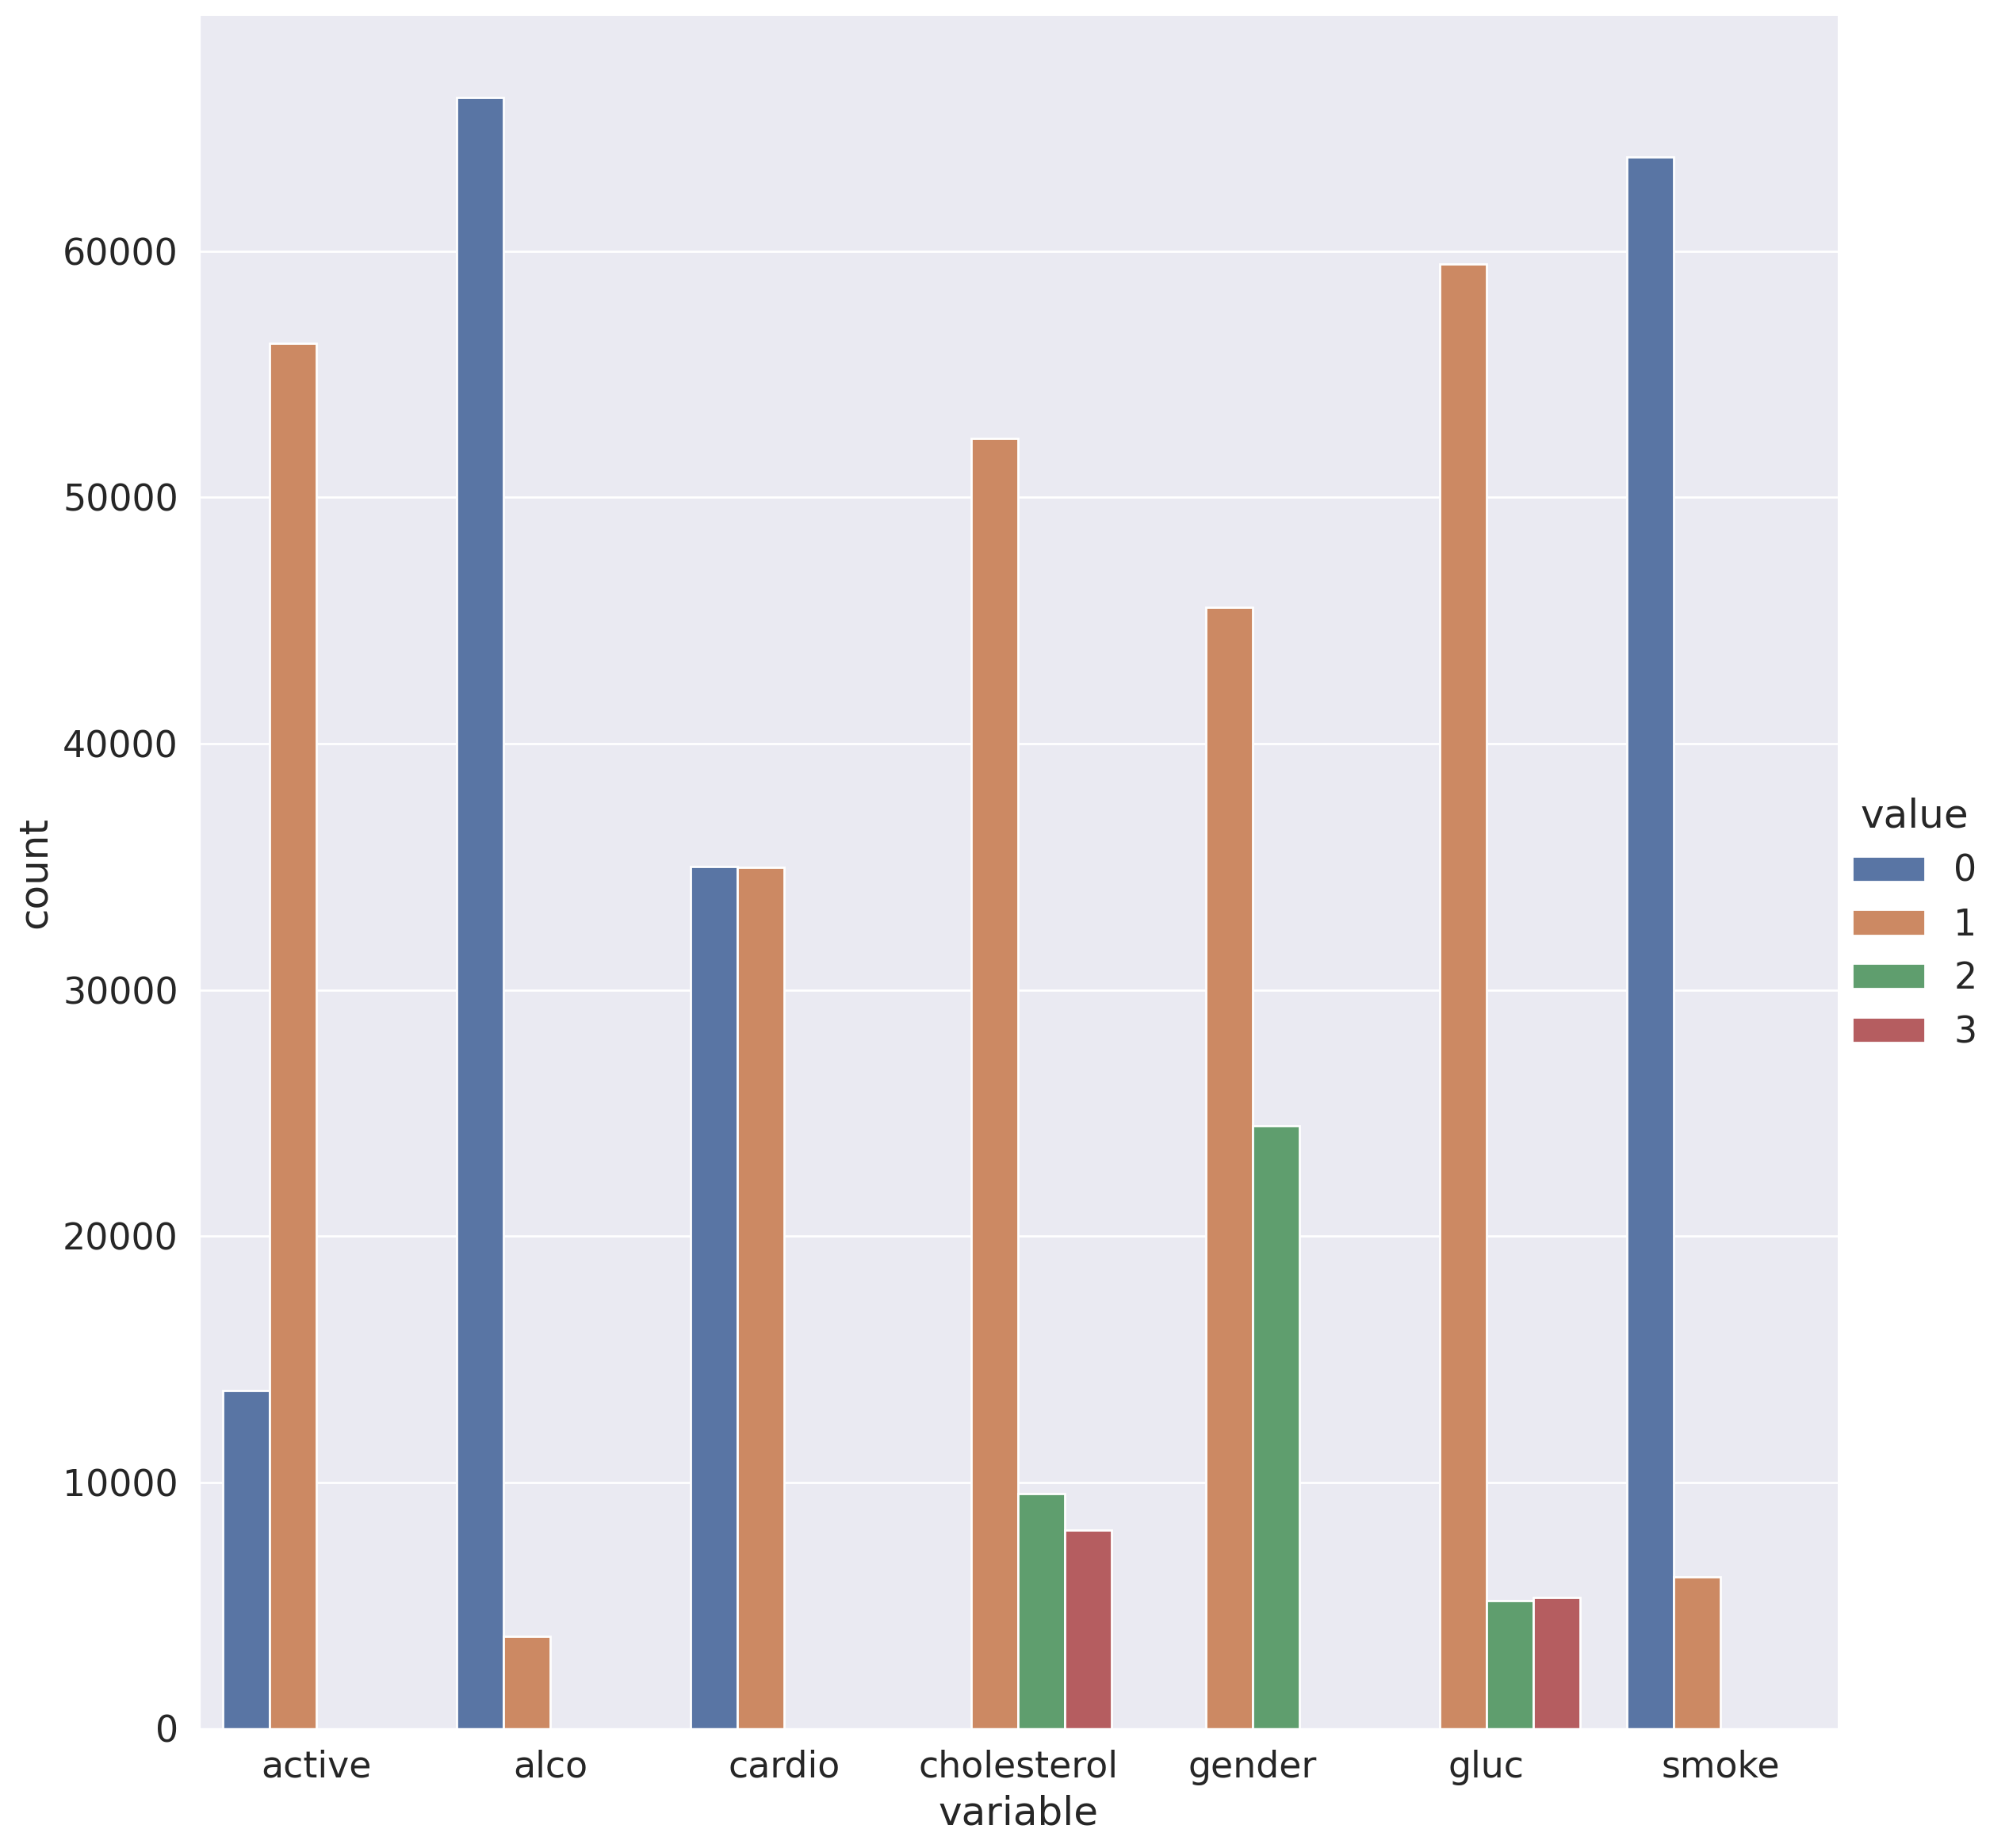

In [4]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", height=12
);

Мы видим, что целевые классы сбалансированы. Это замечательно!

Давайте разделим набор данных по целевым значениям. Можете ли вы уже сейчас, просто взглянув на график, выделить наиболее значимую особенность?

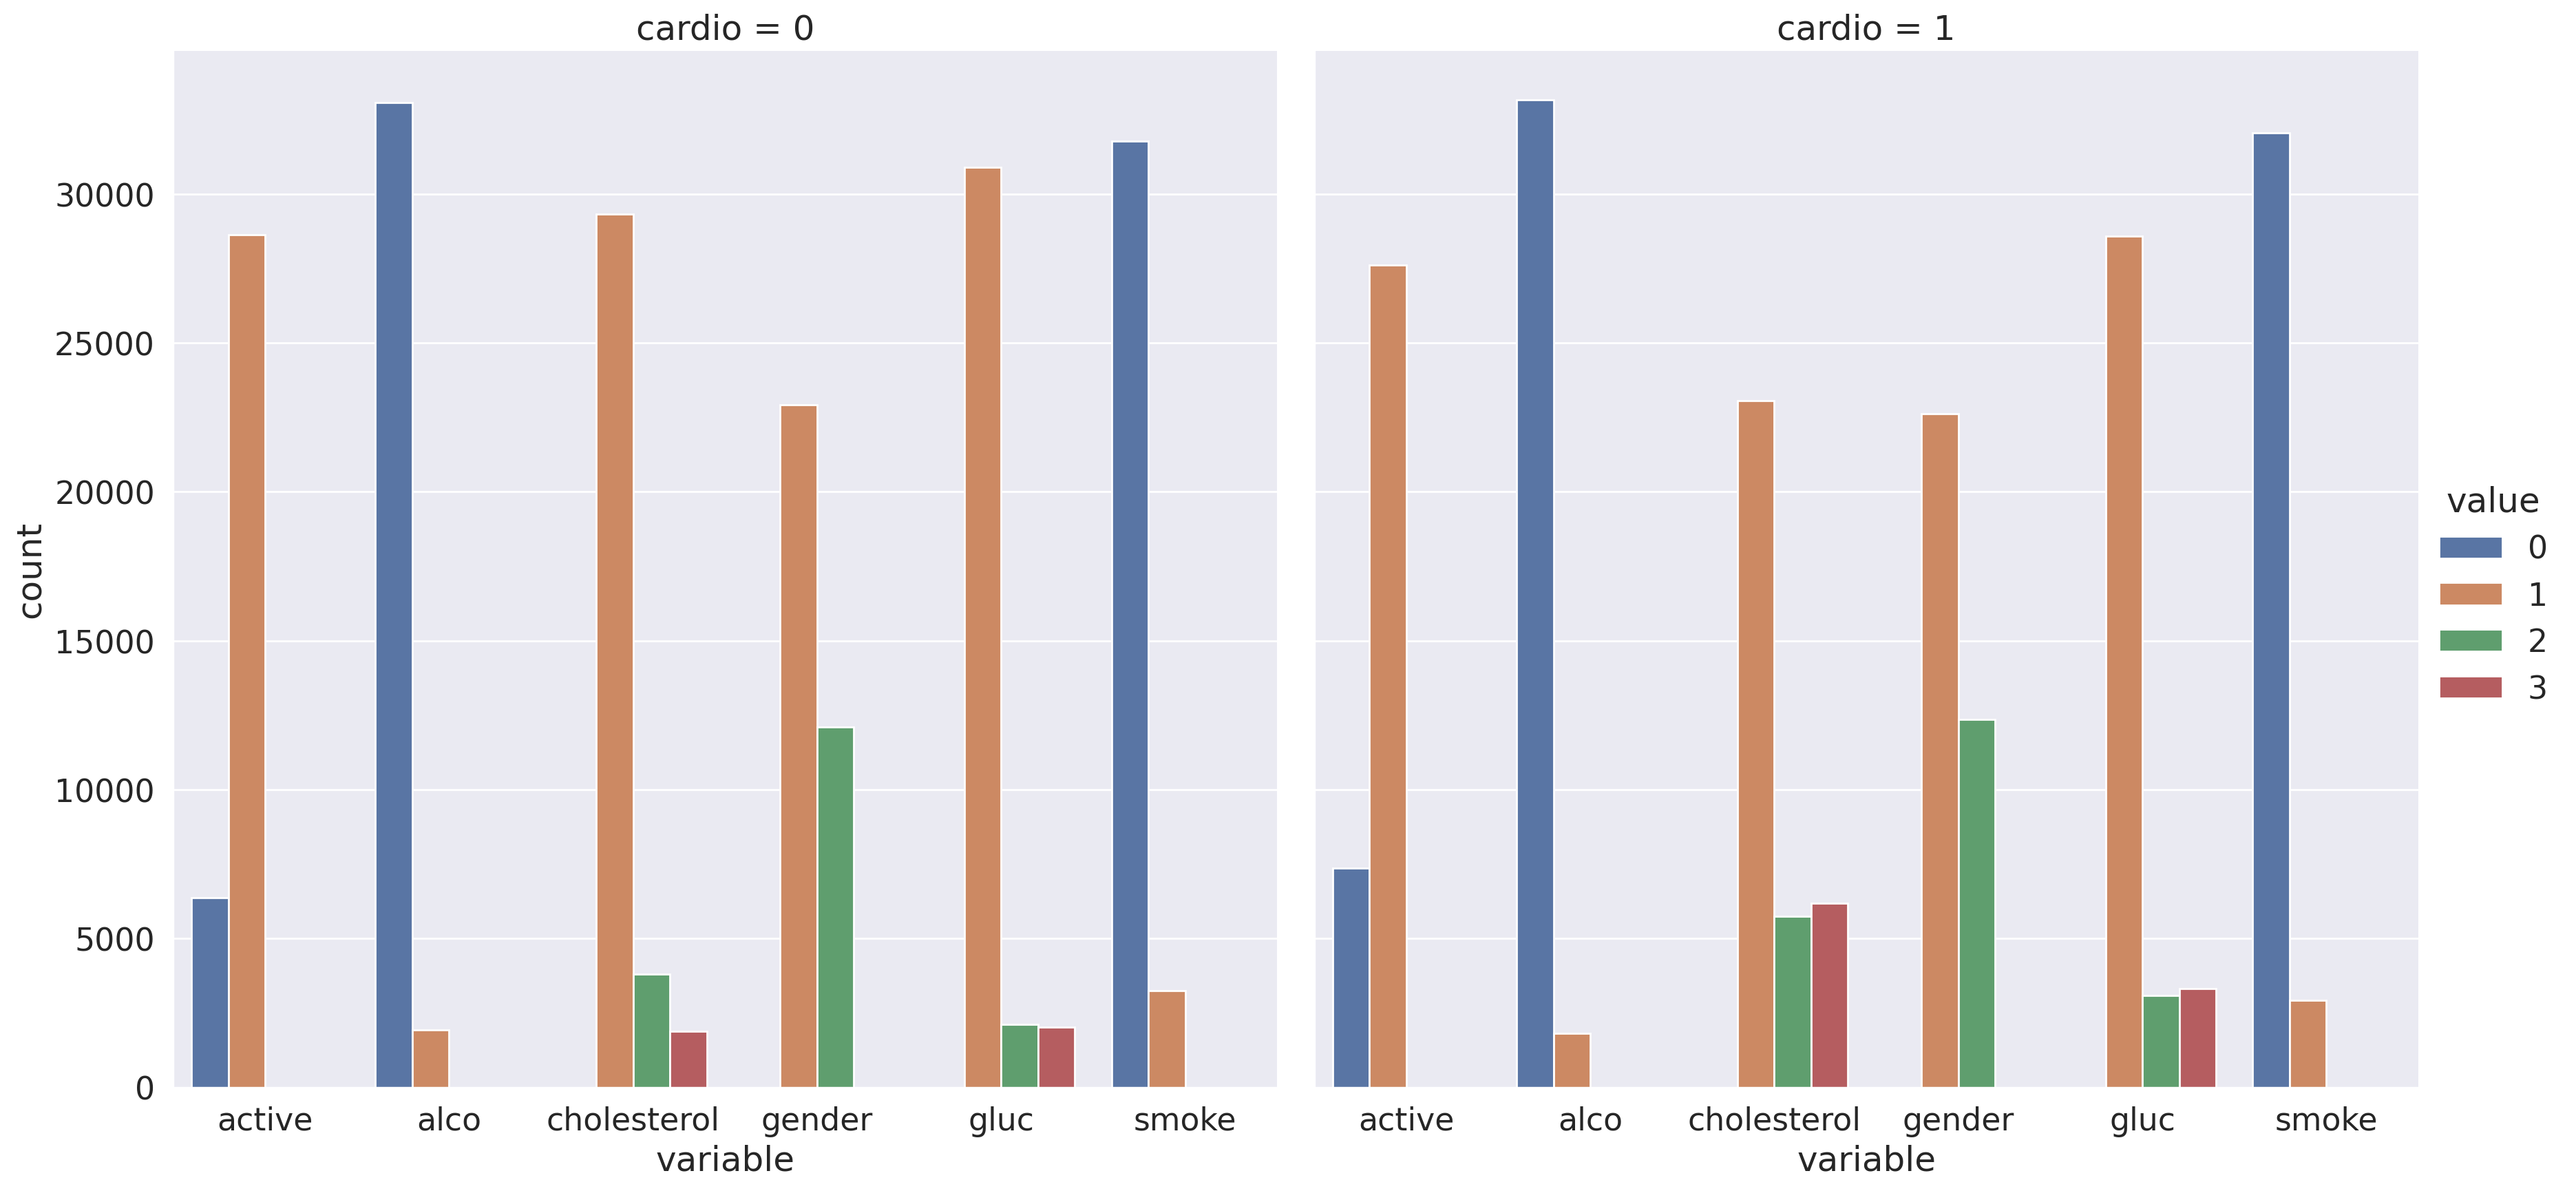

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
    height=9,
);

Видно, что распределение уровней холестерина и глюкозы сильно отличается по значению целевой переменной. Является ли это совпадением?

Теперь рассчитаем статистику для уникальных значений признака:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


В итоге мы имеем:
- 5 числовых признаков (без учета *id*);
- 7 категориальных признаков;
- 70000 записей.

## 1.1. Основные наблюдения

**1.1. (1 point). Сколько мужчин и женщин присутствует в данном наборе данных? Значения признака `gender` не были указаны (означает ли "1" женщин или мужчин) - выясните это, проанализировав рост, исходя из предположения, что мужчины в среднем выше**.
1. 45530 женщин и 24470 мужчин
2. 45530 мужчин и 24470 женщин
3. 45470 женщин и 24530 мужчин
4. 45470 мужчин и 24530 женщин

In [7]:
df.groupby("gender")["height"].mean() # Answer 1

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

**1.2. (1 point). Представители какого пола чаще употребляют алкоголь - мужчины или женщины?**
1. женщины
2. мужчины

In [8]:
df.groupby("gender")["alco"].mean() # Answer 2

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

**1.3. (1 point). Какова разница между процентным соотношением курящих мужчин и женщин (округленно)?**
1. 4
2. 16
3. 20
4. 24

In [9]:
smokers_percentages = df.groupby("gender")["smoke"].mean().apply(lambda x: round(x * 100., 0))
abs(smokers_percentages.loc[1] - smokers_percentages.loc[2]) # Answer 3

20.0

**1.4. (1 point). Какова разница между медианными (median) значениями возраста для курящих и некурящих людей (в месяцах, округленно)? Вам необходимо выяснить единицы измерения признака `age` в этом наборе данных.**

1. 5
2. 10
3. 15
4. 20

In [10]:
median_age = df.groupby("smoke")["age"].median() / 365.25
print(median_age)

print(abs(median_age[0] - median_age[1]) * 12) # Answer 4

smoke
0    53.995893
1    52.361396
Name: age, dtype: float64
19.61396303901438


## 1.2. Карты рисков
### Задание:

На сайте Европейского общества кардиологов приведена шкала [SCORE](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts). Она используется для расчета риска смерти от сердечно-сосудистых заболеваний в ближайшие 10 лет. Вот она:
<img src='../img/SCORE2007-eng.png' width=70%>

Посмотрим на правый верхний прямоугольник, в котором изображено подмножество курящих мужчин в возрасте от 60 до 65 лет (это не очевидно, но значения на рисунке представляют собой верхнюю границу).

В левом нижнем углу прямоугольника мы видим значение 9, а в правом верхнем - 47. Это означает, что для людей данной половозрастной группы, чье систолическое давление не превышает 120, риск ССЗ оценивается в 5 раз ниже, чем для тех, у кого давление находится в интервале [160,180).

Рассчитаем это же соотношение на основе наших данных.

Пояснения:
- Вычислить признак ``age_years`` - округлить возраст до ближайшего числа лет. Для данной задачи выбираем только людей в возрасте от 60 до 64 лет включительно.
- Категории уровня холестерина на рисунке и в нашем наборе данных различаются. Пересчет для признака ``cholesterol`` производится следующим образом: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

**1.5. (2 points). Рассчитайте долю людей с ССЗ для двух описанных выше групп. Каково соотношение этих двух групп?**

1. 1
2. 2
3. 3
4. 4

In [11]:
df["age_years"] = round(df["age"] / 365.25).astype("int")

Выберем курящих мужчин возрастом [60, 65):

In [12]:
smoking_old_men = df.query('(gender == 2) & (smoke == 1) & (age_years >= 60) & (age_years < 65)')

Если уровень холестерина в этой возрастной группе равен 1, а систолическое давление ниже 120, то доля людей с ССЗ составляет:

In [13]:
p1 = (smoking_old_men.query('(cholesterol == 1) & (ap_hi < 120)')["cardio"].mean() * 100.).round(2)

Если же уровень холестерина в этой возрастной группе равен 3, а систолическое давление составляет от 160 до 180, то доля людей с ССЗ составляет:

In [14]:
p2 = (smoking_old_men.query('(cholesterol == 3) & (ap_hi >= 160) & (ap_hi < 180)')["cardio"].mean() * 100.).round(2)

In [15]:
p2 / p1 # Answer 3

3.281155015197568

В результате разница составляет примерно 3 раза. Не в 5 раз, как говорит нам шкала SCORE, но возможно, что риск ССЗ по шкале SCORE нелинейно зависит от доли больных людей в данной возрастной группе.

## 1.3. Анализ индекса массы тела (ИМТ)
### Задание:

Создайте новую характеристику - ИМТ (признак _BMI_) ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого необходимо вес в килограммах разделить на квадрат роста в метрах. Считается, что нормальные значения ИМТ находятся в пределах от 18,5 до 25.

In [16]:
df["bmi"] = df["weight"] / (df["height"] / 100.) ** 2

**1.6. (2 points). Выберите верные утверждения:**

1. Медиана (median) ИМТ в выборке находится в диапазоне нормальных значений ИМТ.
2. Индекс массы тела у женщин в среднем выше, чем у мужчин.
3. У здоровых людей ИМТ в среднем выше, чем у людей с ССЗ.
4. У здоровых, непьющих мужчин ИМТ ближе к норме, чем у здоровых, непьющих женщин.

In [17]:
df["bmi"].median() # Statement 1: incorrect

26.374068120774975

In [18]:
df.groupby("gender")["bmi"].mean() # Statement 2: correct

gender
1    27.987583
2    26.754442
Name: bmi, dtype: float64

In [19]:
print(df.groupby("cardio")["bmi"].mean()) # Statement 3: correct

cardio
0    26.548175
1    28.566061
Name: bmi, dtype: float64


In [20]:
df.groupby(["gender", "alco", "cardio"])["bmi"].median().to_frame()
# Сравнивая значения ИМТ в рядах, где alco=0 и cardio=0, мы видим, что утверждение верно
# Statement 4: correct

bmi
gender alco cardio           
1      0    0       25.654372
            1       27.885187
       1    0       27.885187
            1       30.110991
2      0    0       25.102391
            1       26.674874
       1    0       25.351541
            1       27.530797

## 1.4. Очистка данных

### Задание:

Мы видим, что данные не идеальны. В них есть "грязь" и неточности. Мы увидим это лучше, когда визуализируем данные.

Отфильтруем следующие сегменты пациентов (мы рассматриваем их как ошибочные данные):

- диастолическое давление выше систолического; 
- рост строго меньше 2.5 процентиля;
- рост строго больше 97.5 перцентиля;
- вес строго меньше 2.5 перцентиля;
- вес строго больше 97.5 перцентиля;

Это далеко не все, что мы можем сделать для очистки данных, но пока этого достаточно.

In [21]:
df_to_remove = df[
    (df["ap_lo"] > df["ap_hi"])
    | (df["height"] < df["height"].quantile(0.025))
    | (df["height"] > df["height"].quantile(0.975))
    | (df["weight"] < df["weight"].quantile(0.025))
    | (df["weight"] > df["weight"].quantile(0.975))
]

filtered_df = df[~df.index.isin(df_to_remove)]

**1.7. (2 points). Какой процент исходных данных (округленно) мы выбросили?**

1. 8
2. 9
3. 10
4. 11

In [22]:
round(df_to_remove.shape[0] / df.shape[0] * 100., 2) # Answer: 3

9.63

# Часть 2. Визуальный анализ данных

## 2.1. Визуализация матрицы корреляции

Для лучшего понимания признаков можно создать матрицу коэффициентов корреляции между ними. Используйте исходный набор данных (без фильтрации).

### Задание:

Построить корреляционную матрицу с помощью [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). Матрицу можно создать стандартными средствами `pandas` с параметрами по умолчанию.

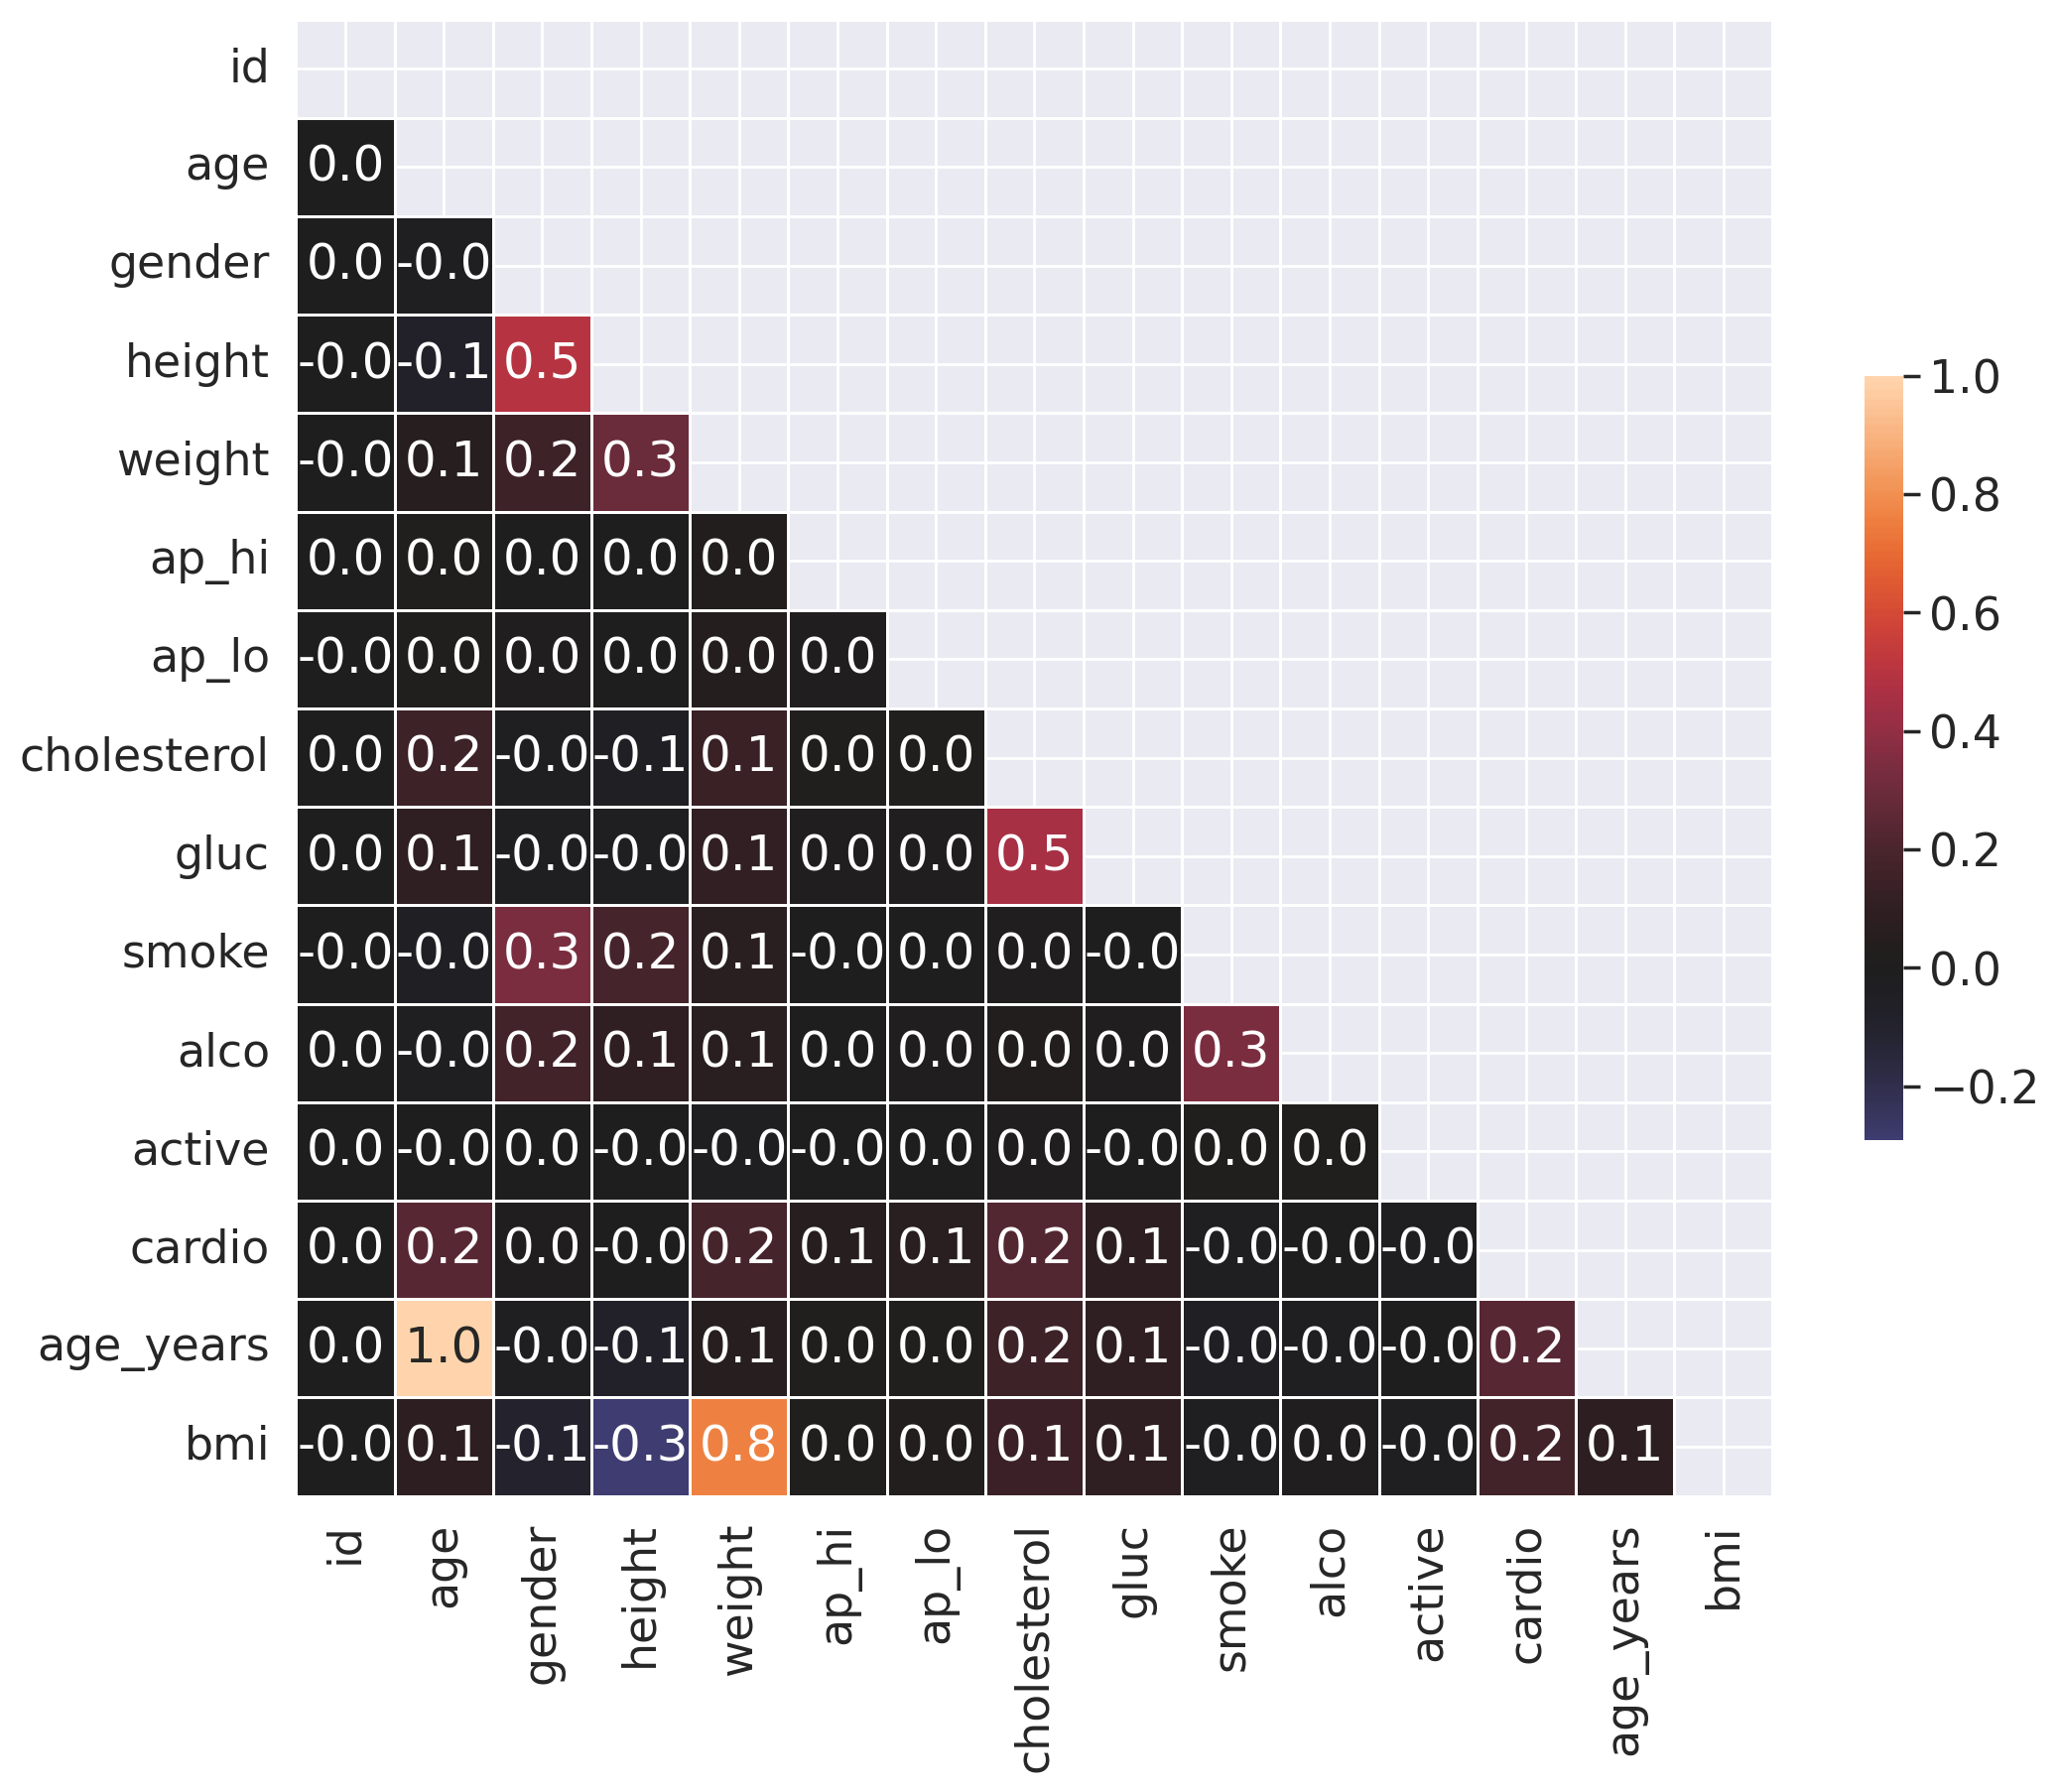

In [23]:
df = filtered_df.copy()
corr = df.corr(method="pearson")

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".1f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

**2.1. (1 point). Какая пара признаков имеет наиболее сильную корреляцию Пирсона (Pearson's correlation) с признаком *gender*?**

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

Ответ: 2

## 2.2. Распределение мужчин и женщин по росту

Из нашего исследования уникальных значений ранее мы знаем, что пол кодируется значениями *1* и *2*. Хотя отображение этих значений на пол неизвестно, это можно выяснить графически, посмотрев на средние значения роста и веса для каждого значения признака *gender*.

### Задание:

Построить скрипичный график для роста и пола с помощью [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Используйте параметры:
- `hue` для разделения по полу;
- `scale` для оценки количества записей для каждого пола.

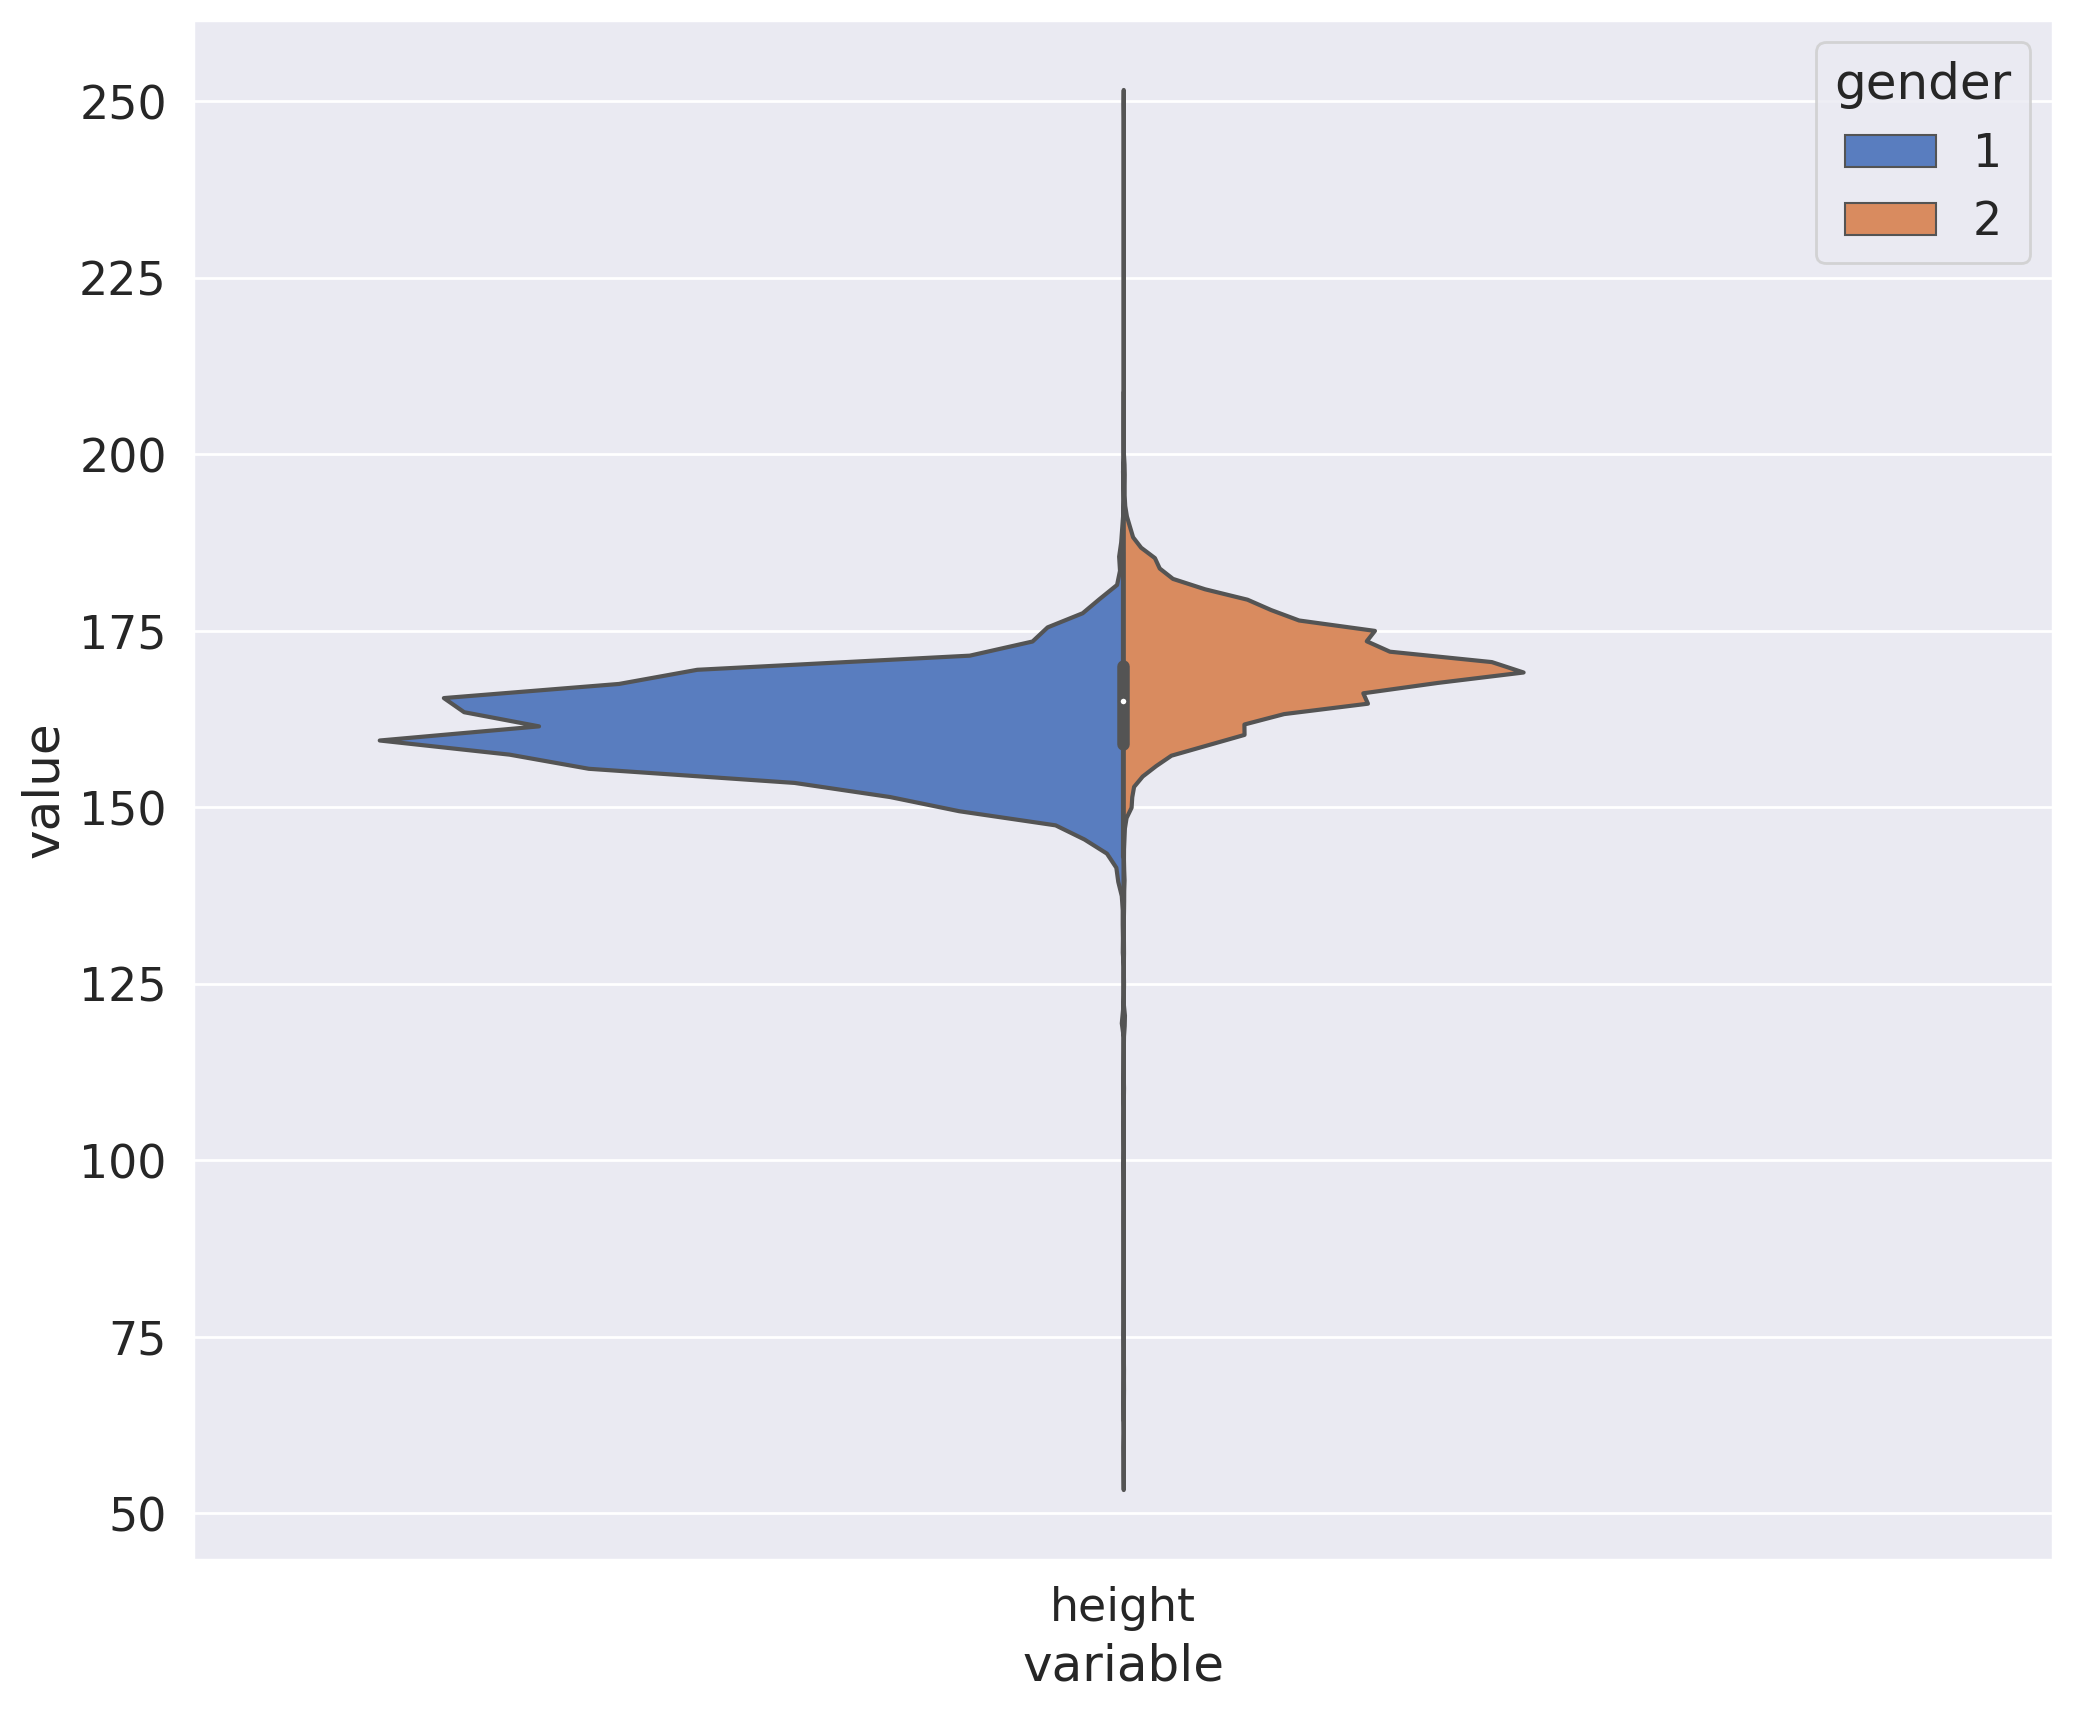

In [24]:
df_melt = pd.melt(frame=df, value_vars=["height"], id_vars=["gender"])
plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    data=df_melt,
    x="variable",
    y="value",
    hue="gender",
    palette="muted",
    split=True,
    scale="count",
    scale_hue=False,
)

## 2.3. Ранговая корреляция

В большинстве случаев для выявления закономерностей в данных более чем достаточно *коэффициента линейной корреляции Пирсона*. Но давайте пойдем немного дальше и рассчитаем [ранговую корреляцию](https://en.wikipedia.org/wiki/Rank_correlation). Это поможет нам выявить такие пары признаков, в которых более низкий ранг в вариационном ряду одного признака всегда опережает более высокий ранг другого (а в случае отрицательной корреляции мы имеем обратное).

### Задание:

Рассчитать и построить корреляционную матрицу с использованием [коэффициента ранговой корреляции Спирмена](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

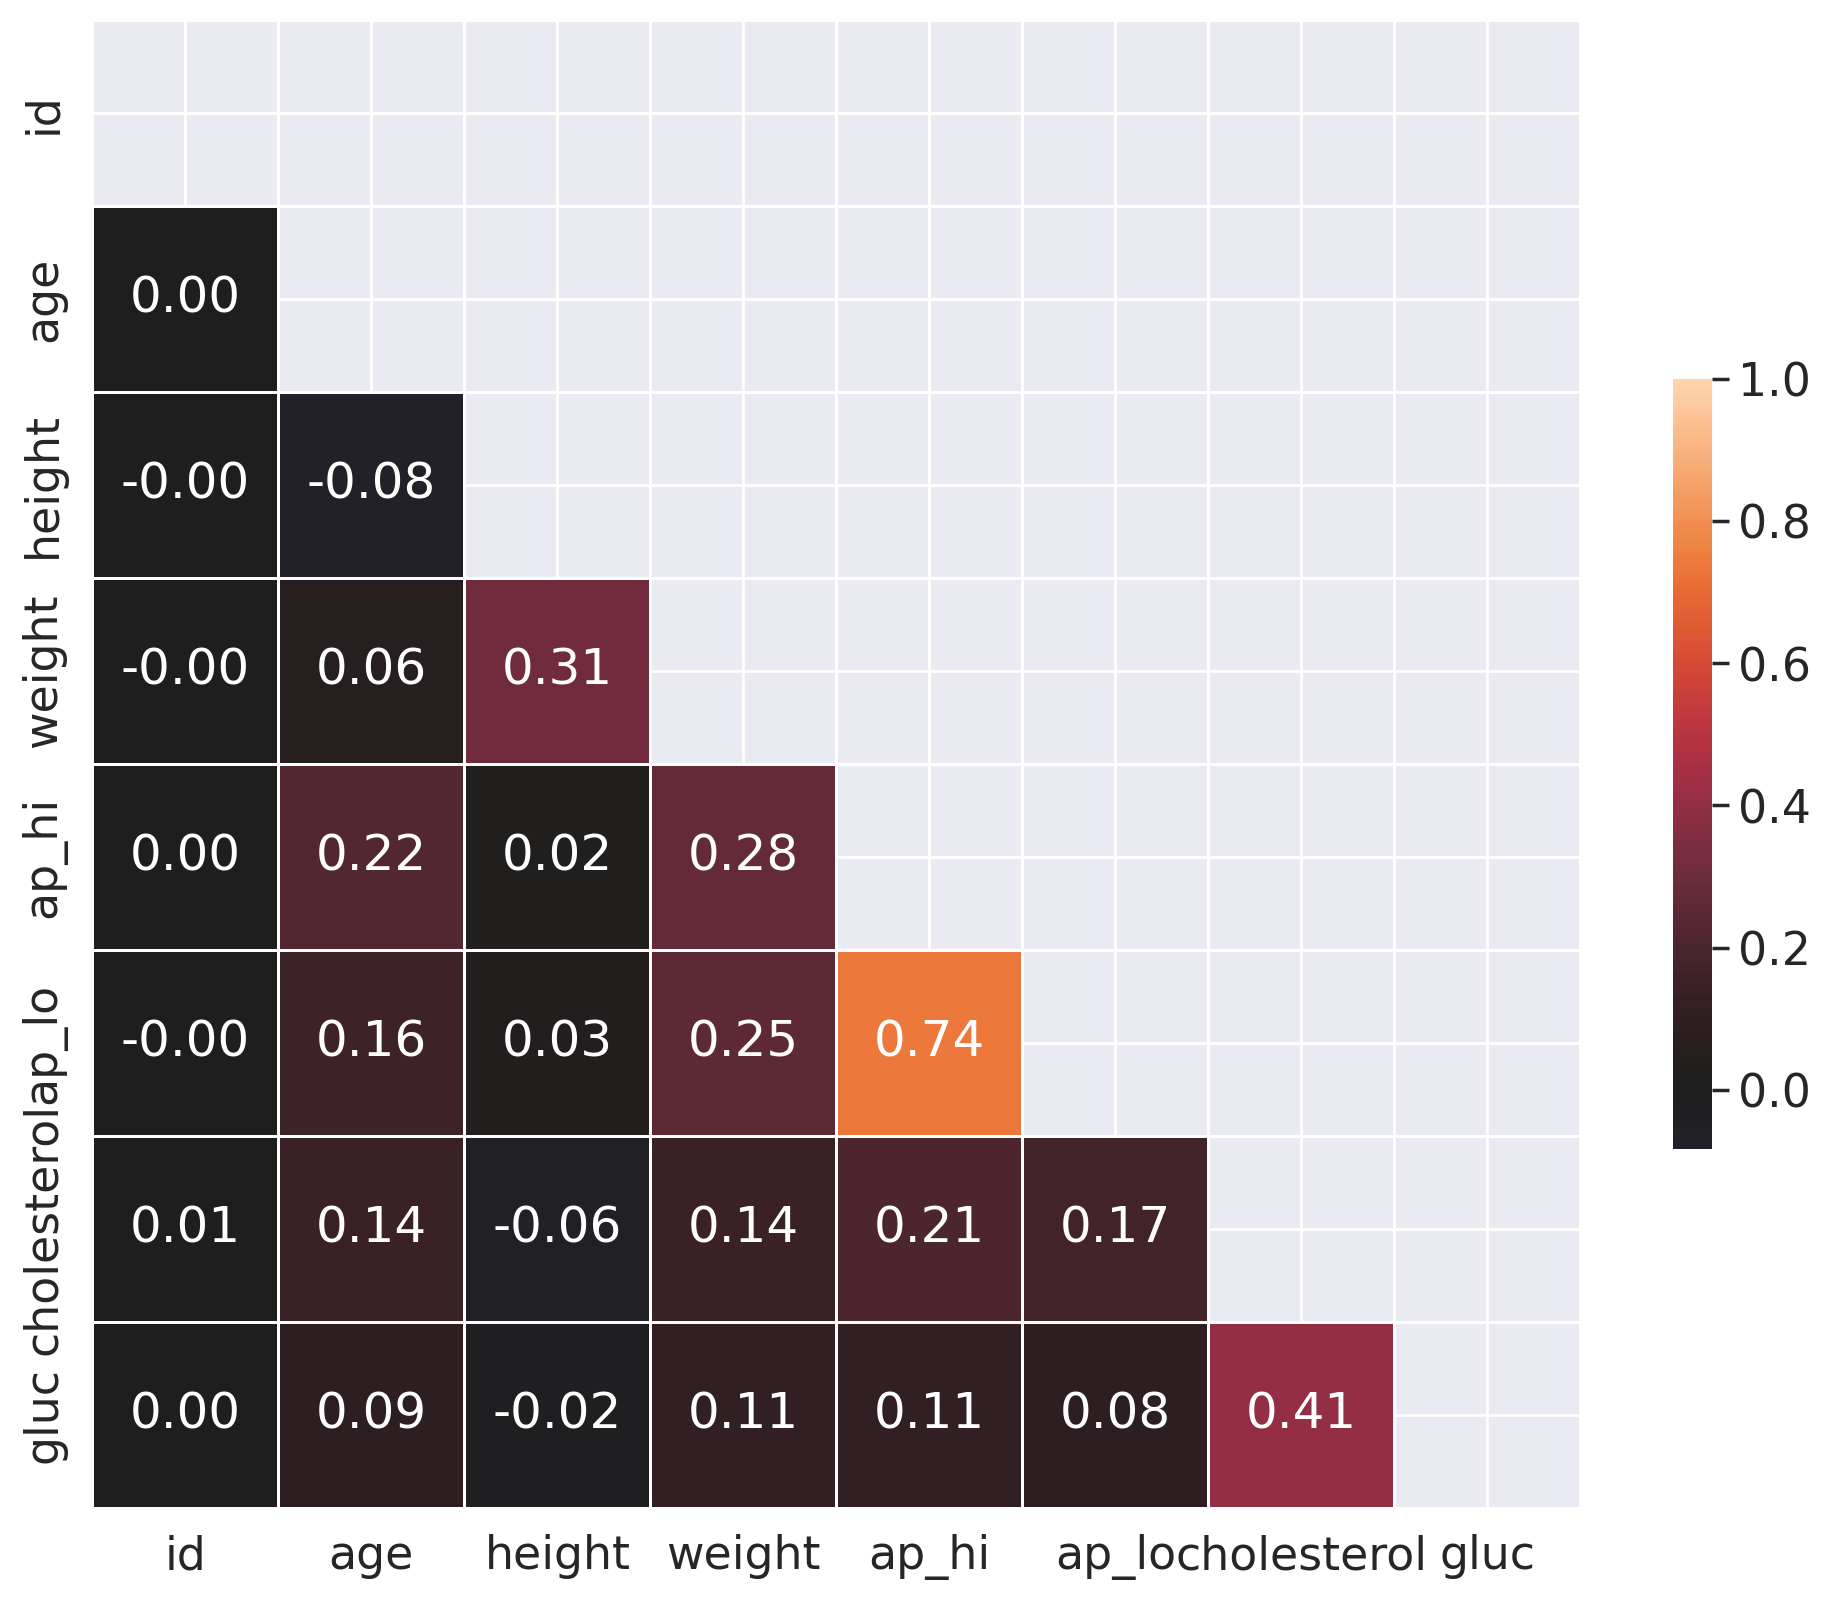

In [25]:
corr = df[
    ["id", "age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"]
].corr(method="spearman")

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

**2.2. (1 point). Какая пара признаков имеет самую сильную корреляцию Спирмена?**

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

Ответ: 5

**2.3. (1 point). Почему эти признаки имеют сильную ранговую корреляцию?**

1. Неточности в данных (ошибки сбора данных).
2. Неправильная связь, эти признаки не должны быть связаны.
3. Характер данных.

Ответ: 3

## 2.4. Возраст

Ранее мы рассчитали возраст респондентов в годах на момент обследования.

### Задание:

Создайте *count plot* с помощью [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html), отложив по оси *X* возраст, а по оси *Y* - количество человек. Полученный график должен содержать два столбца для каждого возраста, соответствующие количеству людей в каждом классе *cardio* в этом возрасте.

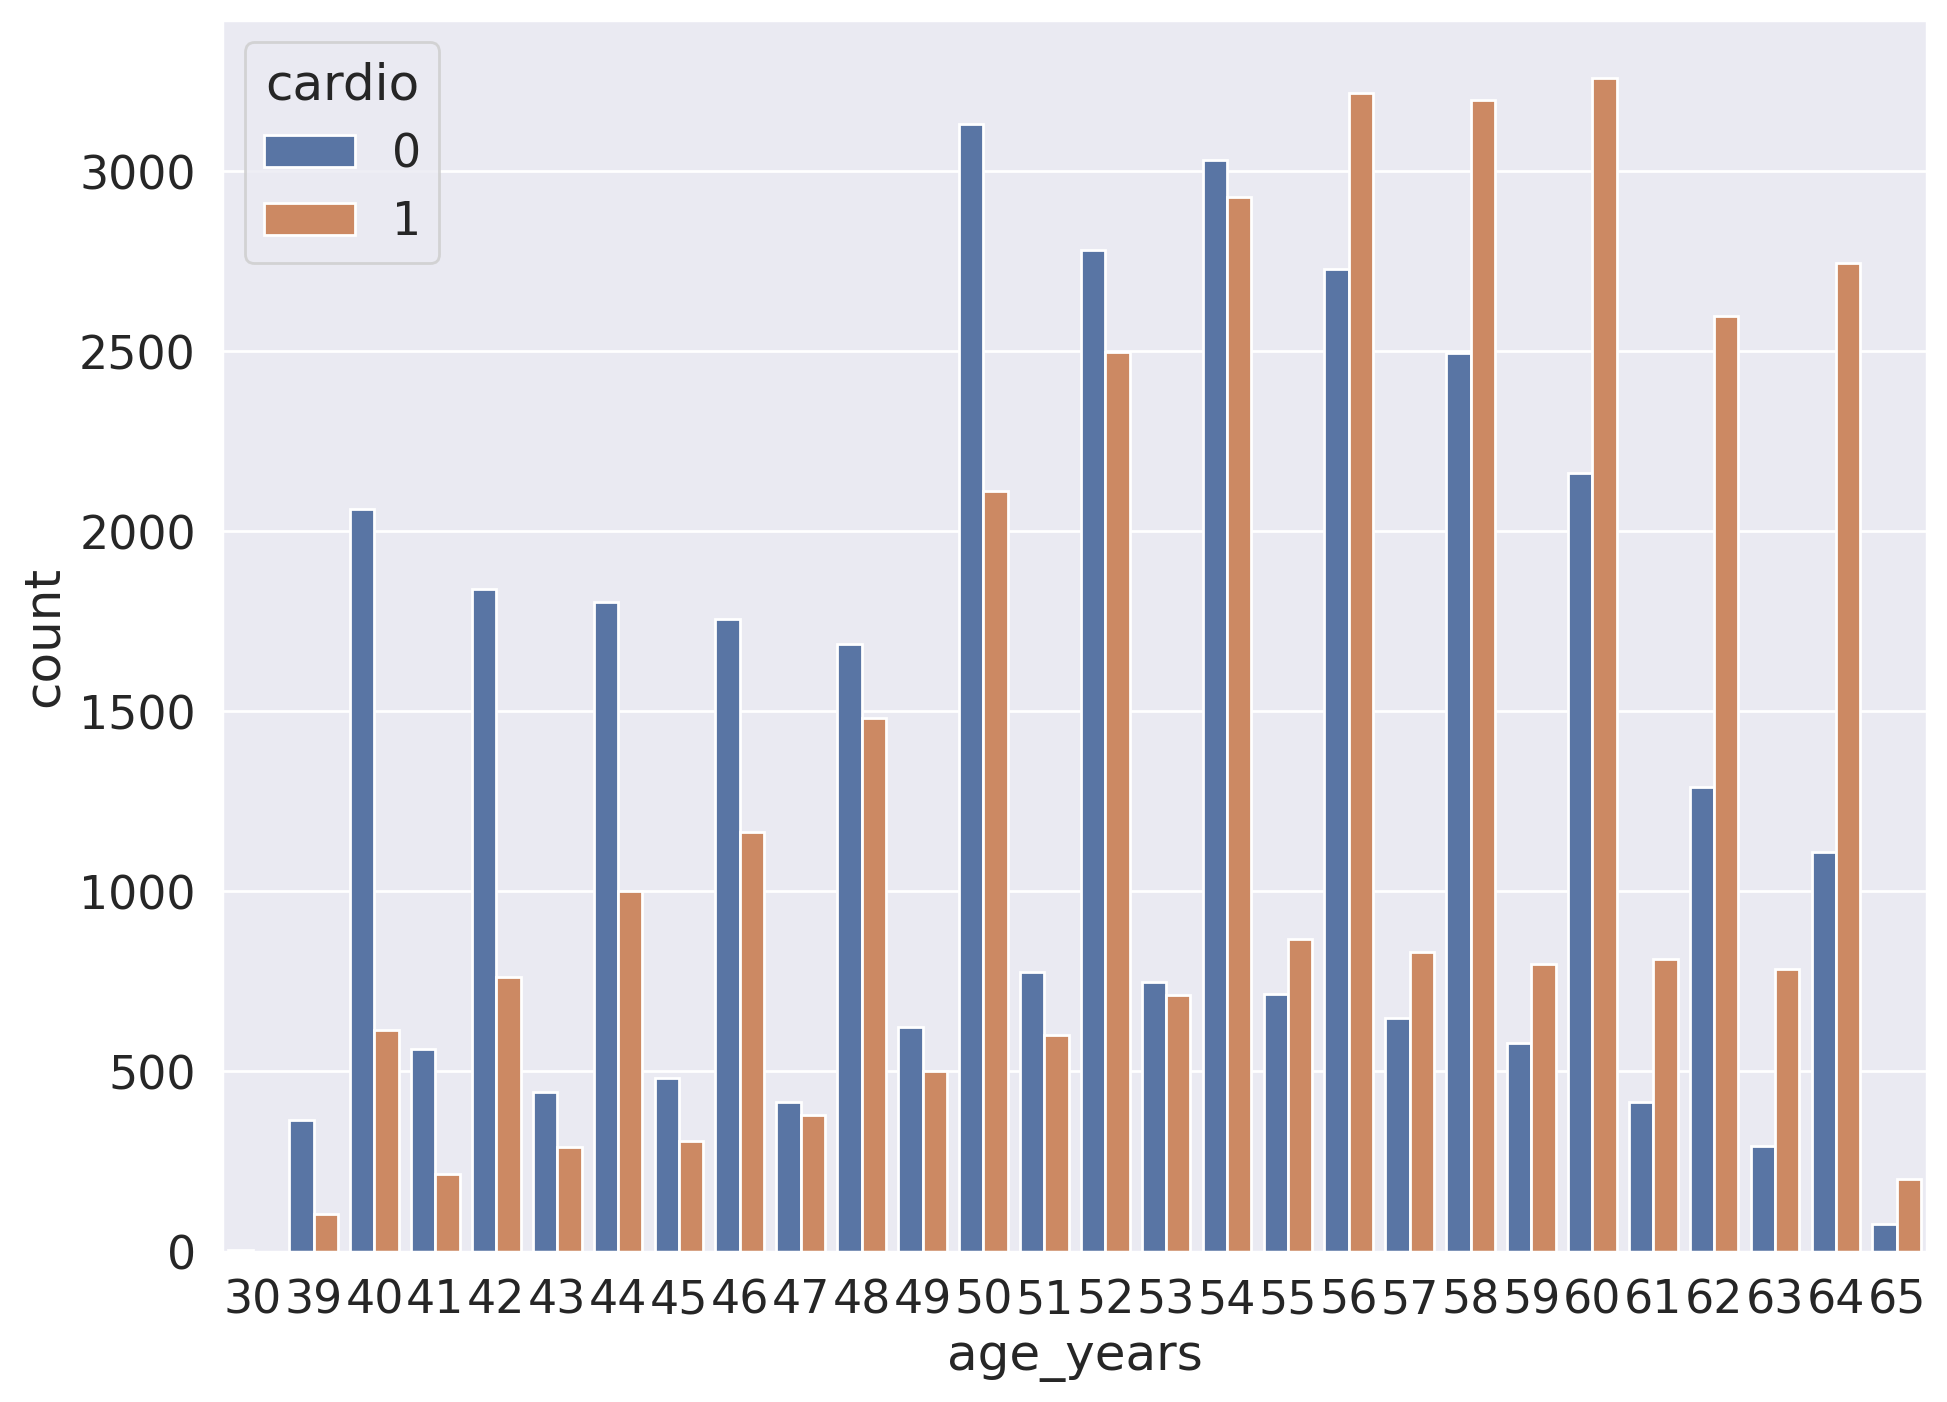

In [26]:
sns.countplot(
    data=df,
    x="age_years",
    hue="cardio"
);

**2.4. (1 point). Каков наименьший возраст, в котором число людей с ССЗ превышает число людей без ССЗ?**

1. 44
2. 55
3. 64
4. 70

Ответ: 2